🚀 Training models...

📊 Evaluation results:


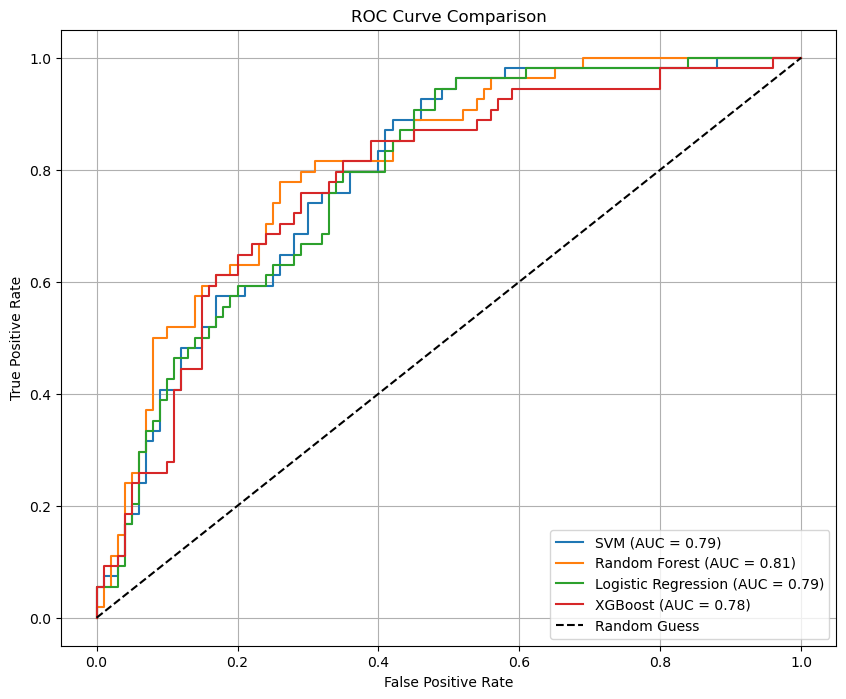


🏆 Best Model: Random Forest
Accuracy: 75.32%
AUC: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.67      0.57      0.62        54

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154


🔍 Feature Importance:
   Feature  Importance
0  Glucose    0.082468
1      BMI    0.031818
2      Age    0.025974


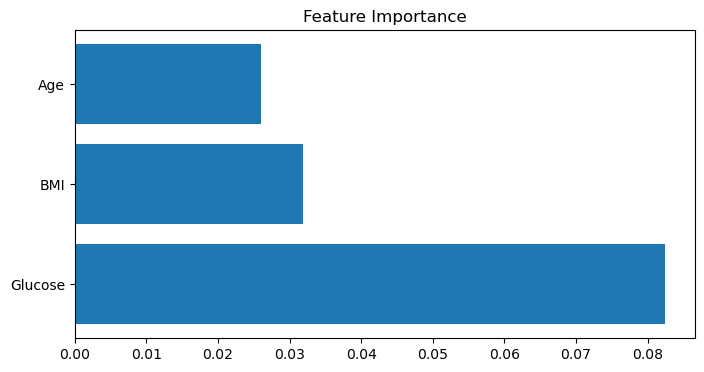


💾 Model saved as 'best_diabetes_model.sav'

🔮 Example Clinical Prediction:

Input Features:
Glucose: 166 mg/dL
BMI: 25.8
Age: 51 years

Clinical Assessment:
Prediction: Diabetic
Probability: 80.2%
Risk Factors: High glucose (166 mg/dL), Age > 45 (51 years)
Recommended Action: Immediate endocrinologist evaluation


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           roc_auc_score, roc_curve, auc, confusion_matrix)
from sklearn.inspection import permutation_importance

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ====================== DATA PREPARATION ======================
def load_data():
    """Load and preprocess diabetes dataset"""
    df = pd.read_csv("C:\\Users\\khade\\Downloads\\diabetes.csv")
    X = df[['Glucose', 'BMI', 'Age']]  # Selected features
    y = df['Outcome']
    return X, y

# ====================== MODEL TRAINING ======================
def train_models(X_train, y_train):
    """Train and compare multiple models"""
    models = {
        "SVM": SVC(kernel='linear', probability=True, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=150, 
                                              max_depth=5, 
                                              random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, 
                                                random_state=42),
        "XGBoost": XGBClassifier(eval_metric='logloss', 
                                random_state=42)
    }
    
    for name, model in models.items():
        model.fit(X_train, y_train)
    return models

# ====================== EVALUATION ======================
def evaluate_models(models, X_test, y_test):
    """Evaluate models and plot ROC curves"""
    plt.figure(figsize=(10, 8))
    results = {}
    
    for name, model in models.items():
        # Predictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        # Store results
        results[name] = {
            'accuracy': accuracy,
            'auc': roc_auc,
            'confusion_matrix': cm,
            'report': report
        }
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    # Plot formatting
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
    return results

# ====================== FEATURE ANALYSIS ======================
def analyze_features(model, X_test, y_test):
    """Analyze feature importance"""
    # Permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, 
                                  random_state=42)
    importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': result.importances_mean
    }).sort_values('Importance', ascending=False)
    
    print("\n🔍 Feature Importance:")
    print(importance)
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.title('Feature Importance')
    plt.show()

# ====================== PREDICTION ======================
def predict_diabetes(model, glucose, bmi, age, threshold=0.3):
    """Make single prediction with enhanced output format"""
    input_data = pd.DataFrame([[glucose, bmi, age]], 
                             columns=['Glucose', 'BMI', 'Age'])
    proba = model.predict_proba(input_data)[0][1]
    
    # Risk factors
    risks = []
    if glucose > 140: risks.append(f"High glucose ({glucose} mg/dL)")
    if bmi > 30: risks.append(f"Obese (BMI: {bmi:.1f})")
    if age > 45: risks.append(f"Age > 45 ({age} years)")
    
    return {
        'prediction': "Diabetic" if proba >= threshold else "Not Diabetic",
        'probability': f"{proba:.1%}",
        'risk_factors': ", ".join(risks) if risks else "No significant risks",
        'action': "No action needed" if proba < 0.3 else 
                 "Primary care consult" if proba < 0.7 else 
                 "Immediate endocrinologist evaluation"
    }

# ====================== MAIN EXECUTION ======================
if __name__ == "__main__":
    # Load data
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Train models
    print("🚀 Training models...")
    models = train_models(X_train, y_train)
    
    # Evaluate
    print("\n📊 Evaluation results:")
    results = evaluate_models(models, X_test, y_test)
    
    # Display metrics for best model
    best_model_name = max(results, key=lambda x: results[x]['auc'])
    best_model = models[best_model_name]
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"Accuracy: {results[best_model_name]['accuracy']:.2%}")
    print(f"AUC: {results[best_model_name]['auc']:.2f}")
    print("\nClassification Report:")
    print(results[best_model_name]['report'])
    
    # Feature analysis
    analyze_features(best_model, X_test, y_test)
    
    # Save best model
    pickle.dump(best_model, open('best_diabetes_model.sav', 'wb'))
    print("\n💾 Model saved as 'best_diabetes_model.sav'")
    
    # Example prediction with new output format
    print("\n🔮 Example Clinical Prediction:")
    case = {'glucose': 166, 'bmi': 25.8, 'age': 51}
    pred = predict_diabetes(best_model, **case)
    
    print(f"\nInput Features:")
    print(f"Glucose: {case['glucose']} mg/dL")
    print(f"BMI: {case['bmi']:.1f}")
    print(f"Age: {case['age']} years")
    
    print(f"\nClinical Assessment:")
    print(f"Prediction: {pred['prediction']}")
    print(f"Probability: {pred['probability']}")
    print(f"Risk Factors: {pred['risk_factors']}")
    print(f"Recommended Action: {pred['action']}")